# Data Preparation

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore, zmap
from sklearn.model_selection import train_test_split
!pip install pyreadstat

#!wget https://www.dropbox.com/s/j87v0iadlmic63g/carsales.sav  # 链接报错  我放了一个原名Car Sales Sample with Performance.sav 作为替代，名字还是改成carsales.sav
!wget https://www.dropbox.com/s/7rd15y2jdam5wls/carsales.sav
!wget https://www.dropbox.com/s/6fadbk6xjmyfxzd/Professional_Sales_Applicants.sav

df= pd.read_spss('carsales.sav')
test= pd.read_spss("Professional_Sales_Applicants.sav")

df=df.dropna()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


     |████████████████████████████████| 2.0MB 2.8MB/s 
--2020-04-26 18:03:00--  https://www.dropbox.com/s/7rd15y2jdam5wls/carsales.sav
Resolving www.dropbox.com (www.dropbox.com)... 162.125.9.1, 2620:100:601f:1::a27d:901
Connecting to www.dropbox.com (www.dropbox.com)|162.125.9.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/7rd15y2jdam5wls/carsales.sav [following]
--2020-04-26 18:03:01--  https://www.dropbox.com/s/raw/7rd15y2jdam5wls/carsales.sav
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uce8c80c0a00fb376e0daf9fe137.dl.dropboxusercontent.com/cd/0/inline/A2miKltnzGay7bIhKxiWWanFoGxolKJesCGBr6QKqnPxGNPxILtH3q_DXKsVCd_0hJiGUwndeCARHb9qf0_5YGdXew3Bd6d3NNoIrZvxK7FnfecoOZd6k6cO2y4vrH5-Rpc/file# [following]
--2020-04-26 18:03:01--  https://uce8c80c0a00fb376e0daf9fe137.dl.dropboxusercontent.com/cd/0/inline/A2miKltnzGay7bIhKxiWWanFoGxolKJesCGBr6QKqnPxGNPxILtH3q_DXKs

#Modeling

## # Relationship with existing OverallRating and (Age, Gender, Ethics)

In [0]:
df.orig=df.copy()

#prefer not to say in gender we marked as 'PNS'
df.loc[df["Race"]!='White (not Hispanic or Latino)','race']='Non-white'
df.loc[df["Race"]=='White (not Hispanic or Latino)','race']='white'
df.loc[df["Gender"]!='Male','Gender']='Female&PNS'

#we define age over 40 are old group, prefer not to say as unprivilage group
df['Age']='Old$PNS'
df.loc[df["AgeBand"].isin(['16-19','20-29','30-39']),'Age']='Young'
#df.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  """Entry point for launching an IPython kernel.


In [0]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

# create dummy variables
race=pd.get_dummies(df['race'],drop_first=False)
Age=pd.get_dummies(df['Age'],drop_first=False)
Gender=pd.get_dummies(df['Gender'],drop_first=False)
protected=pd.concat([race,Age,Gender], axis=1)

# regression for the acutal score with age, gender, ethics
results_actual= smf.ols('OverallRating ~ race+Age+Gender', data=df).fit()
print(results_actual.summary())

                            OLS Regression Results                            
Dep. Variable:          OverallRating   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                 -0.008
Method:                 Least Squares   F-statistic:                    0.1936
Date:                Sun, 26 Apr 2020   Prob (F-statistic):              0.901
Time:                        15:53:56   Log-Likelihood:                -467.41
No. Observations:                 313   AIC:                             942.8
Df Residuals:                     309   BIC:                             957.8
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          3.4365      0.158     21.

## Pre processing check bias

transform to aif360 

### Check the small data set

In [0]:
!pip install aif360

from aif360.datasets import BinaryLabelDataset
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.metrics import ClassificationMetric
from aif360.algorithms.preprocessing import Reweighing
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from tqdm import tqdm
np.random.seed(1)

     |████████████████████████████████| 56.4MB 75kB/s 


In [0]:
# Select top 80% as recommend, and the bottom 20% at not recommend
# There are total 313 records, we sorted the data based on pred OverallRating, and the separation is 313*20%=63.
print('df have',df.shape[0],'rows\n')
df.sort_values('OverallRating',inplace=True)
df.iloc[63,5:6]

df have 313 rows



OverallRating    2.62778
Name: 436, dtype: object

In [0]:
df['recommend']=0
df.loc[df['OverallRating']> 2.62778,'recommend']=1
print(df.head(3))
df_onehot=pd.concat([df[['recommend']],pd.get_dummies(df[['Age','race','Gender']],drop_first=True)],axis=1)
df_onehot['race_white'].value_counts()

     CandidateID            AgeBand  ...      Age recommend
174     225433.0  Prefer Not To Say  ...  Old$PNS         0
272     236965.0              30-39  ...    Young         0
344     243338.0              40-49  ...  Old$PNS         0

[3 rows x 29 columns]


1    160
0    153
Name: race_white, dtype: int64

In [0]:
df.head(3)

,CandidateID,AgeBand,Race,Gender,QualityofHirePoint,OverallRating,Accommodation_tile,Assertiveness_tile,CautiousThinking_tile,Competitiveness_tile,CriticismTolerance_tile,DetailInterest_tile,FollowThrough_tile,InterpersonalInsight_tile,Multitasking_tile,ObjectiveThinking_tile,Optimism_tile,PositiveViewofPeople_tile,PreferenceforStructure_tile,ProcessFocused_tile,WorkIntensity_tile,RealisticThinking_tile,ReflectiveThinking_tile,Sociability_tile,SocialRestraint_tile,WorkIndependence_tile,race,Age,recommend
174,225433.0,Prefer Not To Say,Prefer Not To Say,Male,-9346.135229,0.643165,0.2525,0.5971,0.8203,0.5852,0.6893,0.4013,0.6419,0.8097,0.0370,0.1981,0.6419,0.3383,0.0067,0.1437,0.5915,0.3331,0.7354,0.3843,0.3556,0.9099,Non-white,Old$PNS,0
272,236965.0,30-39,White (not Hispanic or Latino),Male,-2279.615476,0.775354,0.6915,0.5971,0.9088,0.7692,0.6893,0.9599,0.9655,0.6032,0.9654,0.1981,0.8183,0.7519,0.9006,0.7937,0.5000,0.0169,0.6878,0.5000,0.8228,0.1038,white,Young,0
344,243338.0,40-49,White (not Hispanic or Latino),Male,-5686.210758,0.915098,0.5000,0.9403,0.8203,0.0642,0.5561,0.8413,0.7665,0.7652,0.0036,0.9467,0.8183,0.8301,0.7114,0.6003,0.4085,0.3331,0.7791,0.6157,0.5000,0.3228,white,Old$PNS,0


In [0]:
df_onehot.head()

,recommend,Age_Young,race_white,Gender_Male
174,0,0,0,1
272,0,1,1,1
344,0,0,1,1
318,0,0,0,1
313,0,1,0,0


In [0]:
# Disparity index Function
def get_disparity_index(di):
    return 1 - np.minimum(di, 1 / di)

#### Check Gender

In [0]:
df_gender=BinaryLabelDataset(df=df_onehot,label_names=['recommend'],protected_attribute_names=['Gender_Male'])

In [0]:
privileged_group = [{'Gender_Male': 1}]
unprivileged_group = [{'Gender_Male': 0}]

In [0]:
metric = BinaryLabelDatasetMetric(df_gender, unprivileged_group, privileged_group)
print('Gender: Disparate Impact (normal 0.8-1.2):', metric.disparate_impact().round(3),
'\nStatistical Parity Difference (normal -0.1-0.1)', metric.statistical_parity_difference().round(3))

Gender: Disparate Impact (normal 0.8-1.2): 0.964 
Statistical Parity Difference (normal -0.1-0.1) -0.029


#### check Age

In [0]:
df_age=BinaryLabelDataset(df=df_onehot,label_names=['recommend'],protected_attribute_names=['Age_Young'])

In [0]:
privileged_group = [{'Age_Young': 1}]
unprivileged_group = [{'Age_Young': 0}]

In [0]:
metric = BinaryLabelDatasetMetric(df_age, unprivileged_group, privileged_group)
print('Age: Disparate Impact (normal 0.8-1.2):', metric.disparate_impact().round(3),
'\nStatistical Parity Difference (normal -0.1-0.1)', metric.statistical_parity_difference().round(3))


Age: Disparate Impact (normal 0.8-1.2): 1.067 
Statistical Parity Difference (normal -0.1-0.1) 0.051


#### Check Race

In [0]:
df_race=BinaryLabelDataset(df=df_onehot,label_names=['recommend'],protected_attribute_names=['race_white'])

In [0]:
privileged_group = [{'race_white': 1}]
unprivileged_group = [{'race_white': 0}]

In [0]:
metric = BinaryLabelDatasetMetric(df_race, unprivileged_group, privileged_group)
print('Race: Disparate Impact (normal 0.8-1.2):', metric.disparate_impact().round(3),
'\nStatistical Parity Difference (normal -0.1-0.1)', metric.statistical_parity_difference().round(3))

Race: Disparate Impact (normal 0.8-1.2): 1.013 
Statistical Parity Difference (normal -0.1-0.1) 0.01


### check the test dataset

Fit model, predcit overallrating and check bias (Gender) 

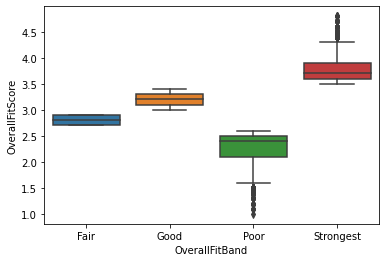

In [0]:
import seaborn as sns
sns.boxplot(x='OverallFitBand',y='OverallFitScore',
    data=test
)

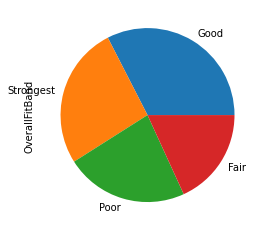

In [0]:
test['OverallFitBand'].value_counts().plot.pie()

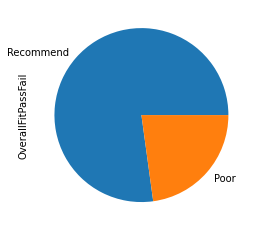

In [0]:
test['OverallFitPassFail'].value_counts().plot.pie()
a,b=test['OverallFitPassFail'].value_counts()[0:2]
print('recommend rate is ', (a/(a+b)))

In [0]:
test['commentcombine']=test['OverallFitBand'].astype(str)+test['OverallFitPassFail'].astype(str)
test['commentcombine'].value_counts()

GoodRecommend         9350
StrongestRecommend    7600
PoorPoor              6560
FairRecommend         5219
Name: commentcombine, dtype: int64

In [0]:
test.iloc[:,1:26].head()

In [0]:
test.orig=test.copy()

#prefer not to say in gender we marked as 'PNS'
test.loc[test["Ethnicity"]!='White (not Hispanic or Latino)','race']='Non-white'
test.loc[test["Ethnicity"]=='White (not Hispanic or Latino)','race']='white'
test.loc[test["Gender"]!='Male','Gender']='Female&PNS'

#we define age over 40 are old group, prefer not to say as unprivilage group
test['Age']='Old$PNS'
test.loc[test["AgeRange"].isin(['16-19','20-29','30-39']),'Age']='Young'

In [0]:
test_onehot=pd.get_dummies(test[['OverallFitPassFail','Age','race','Gender']],drop_first=True)
test_onehot['race_white'].value_counts()

0    16724
1    12005
Name: race_white, dtype: int64

#### Metrics for big data set.

In [0]:
test_gender=BinaryLabelDataset(df=test_onehot,label_names=['OverallFitPassFail_Recommend'],protected_attribute_names=['Gender_Male'])
privileged_group = [{'Gender_Male': 1}]
unprivileged_group = [{'Gender_Male': 0}]
metric = BinaryLabelDatasetMetric(test_gender, unprivileged_group, privileged_group)
print('Gender: Disparate Impact (normal 0.8-1.2):', metric.disparate_impact().round(3),
'\nStatistical Parity Difference (normal -0.1-0.1)', metric.statistical_parity_difference().round(3))

Gender: Disparate Impact (normal 0.8-1.2): 0.99 
Statistical Parity Difference (normal -0.1-0.1) -0.007


In [0]:
test_age=BinaryLabelDataset(df=test_onehot,label_names=['OverallFitPassFail_Recommend'],protected_attribute_names=['Age_Young'])
privileged_group = [{'Age_Young': 1}]
unprivileged_group = [{'Age_Young': 0}]
metric = BinaryLabelDatasetMetric(test_age, unprivileged_group, privileged_group)
print('Age: Disparate Impact (normal 0.8-1.2):', metric.disparate_impact().round(3),
'\nStatistical Parity Difference (normal -0.1-0.1)', metric.statistical_parity_difference().round(3))

Age: Disparate Impact (normal 0.8-1.2): 1.064 
Statistical Parity Difference (normal -0.1-0.1) 0.049


In [0]:
test_race=BinaryLabelDataset(df=test_onehot,label_names=['OverallFitPassFail_Recommend'],protected_attribute_names=['race_white'])
privileged_group = [{'race_white': 1}]
unprivileged_group = [{'race_white': 0}]
metric = BinaryLabelDatasetMetric(test_race, unprivileged_group, privileged_group)
print('Race: Disparate Impact (normal 0.8-1.2):', metric.disparate_impact().round(3),
'\nStatistical Parity Difference (normal -0.1-0.1)', metric.statistical_parity_difference().round(3))

Race: Disparate Impact (normal 0.8-1.2): 0.973 
Statistical Parity Difference (normal -0.1-0.1) -0.021


## What if we FAKE the data into a biased one.

### the original recommend rate in gender

In [0]:
test_dummy=pd.concat([test[['Gender','Age','race']],pd.get_dummies(test[['OverallFitPassFail']],drop_first=True)],axis=1)
#df_onehot=pd.concat([df[['recommend']],pd.get_dummies(df[['Age','race','Gender']],drop_first=True)],axis=1)
test_dummy.head(3)

,Gender,Age,race,OverallFitPassFail_Recommend
0,Male,Young,white,1
1,Male,Young,Non-white,1
2,Male,Young,white,0


Gender
Female&PNS    0.766788
Male          0.774228
Name: OverallFitPassFail_Recommend, dtype: float64


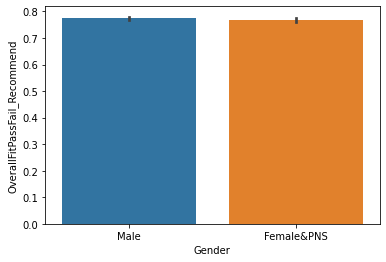

In [0]:
import seaborn as sns
sns.barplot(x='Gender',y='OverallFitPassFail_Recommend',data=test_dummy)
print(test_dummy.groupby('Gender')['OverallFitPassFail_Recommend'].mean())

Gender
Female&PNS    0.708106
Male          0.852693
Name: fake_recommend, dtype: float64


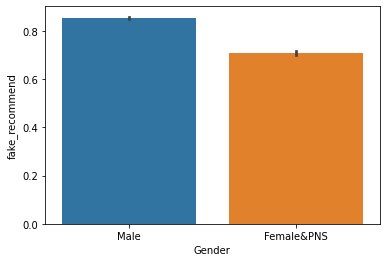

In [0]:
p_recommend_male, p_recommend_female = 0.85, 0.71 # No breaking the four-fifth rule

test_dummy.loc[test_dummy.Gender == 'Male', 'fake_recommend'] = np.random.choice([1, 0], size=len(test_dummy.loc[test_dummy.Gender=='Male']), p=[p_recommend_male, 1 - p_recommend_male])
test_dummy.loc[test_dummy.Gender == 'Female&PNS', 'fake_recommend'] = np.random.choice([1, 0], size=len(test_dummy.loc[test_dummy.Gender=='Female&PNS']), p=[p_recommend_female, 1 - p_recommend_female])
#df.loc[df.gender == 'female', 'found_job'] = np.random.choice([1, 0], size=len(df.loc[df.gender == 'female']), p=[p_job_female, 1 - p_job_female])
test_dummy['fake_recommend'] = test_dummy['fake_recommend'].astype(int)

sns.barplot(x='Gender',y='fake_recommend',data=test_dummy)
print(test_dummy.groupby('Gender')['fake_recommend'].mean())

### Check the bias metric of gender in fake recommend 

In [0]:
test_onehot=pd.concat([test_dummy['fake_recommend'],pd.get_dummies(test_dummy[['Gender']],drop_first=True)],axis=1)
test_onehot.head(3)

,fake_recommend,Gender_Male
0,1,1
1,1,1
2,1,1


In [0]:
test_genderfake=BinaryLabelDataset(df=test_onehot,label_names=['fake_recommend'],protected_attribute_names=['Gender_Male'])
privileged_group = [{'Gender_Male': 1}]
unprivileged_group = [{'Gender_Male': 0}]
metric = BinaryLabelDatasetMetric(test_genderfake, unprivileged_group, privileged_group)
print('Gender: Disparate Impact (normal 0.8-1.2):', metric.disparate_impact().round(3),
'\nStatistical Parity Difference (normal -0.1-0.1)', metric.statistical_parity_difference().round(3))

Gender: Disparate Impact (normal 0.8-1.2): 0.83 
Statistical Parity Difference (normal -0.1-0.1) -0.145


### In the metric check we found bias exists, then we use reweight algorithm to mitigate bias.

In [0]:
RW = Reweighing(unprivileged_group, privileged_group)
test_transf = RW.fit_transform(test_genderfake)
metric_transf = BinaryLabelDatasetMetric(test_transf, unprivileged_group, privileged_group)
#print(':',metric_transf_trn.disparate_impact())

print('Gender: Disparate Impact (normal 0.8-1.2):', metric_transf.disparate_impact().round(3),
'\nStatistical Parity Difference (normal -0.1-0.1)', metric_transf.statistical_parity_difference().round(3))

Gender: Disparate Impact (normal 0.8-1.2): 1.0 
Statistical Parity Difference (normal -0.1-0.1) -0.0


### Now we mitigate the bias